In [1]:
# load data
import os
import pandas as pd
import numpy as np
# test models
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import time
# feature importance plot
import matplotlib.pyplot as plt

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


En utilisant les statistiques des variables pour chacune des series temporelles.

In [2]:
def linearize(u):
    """
    Fonction pour mettre en 1 seule lignes le tableau de statistiques pd.describe()
    """
    all=[]
    for line in range(len(u)):
        all.append(u.iloc[line])
    return pd.concat(all, axis=0).T

def load_data(directory = 'data/group3/config_1', drop_col='', drop_feat=''):

    """
    Fonction pour charger les donnée:
    directory : str() chemin d'acces
    drop_col : list() nom des statistiques à ne pas utiliser (pd.describe())
    drop_feat : list() nom des features à ne pas utiliser

    return : pd.DataFrame()
    """

    all_data=[]
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        data = pd.read_csv(f)
        if drop_col:
            data.drop(columns=drop_col, inplace=True)
        u = data.describe().T
        if drop_feat:
            u.drop(columns=drop_feat, inplace=True)
        number = pd.DataFrame(linearize(u)).T
        # add labels
        if directory == 'data/h_config1-lcb':
            number['label'] = int(filename[2])
        elif directory == 'data/v_config1-lcb':
            number['label'] = int(filename[10])
        elif directory == 'data/groupe1_groupe2':
            number['label'] = int(filename[3])
        else:
            number['label'] = int(filename[0])
        all_data.append(number)

    to_test = pd.concat(all_data)

    new_col=[]
    for stat_ in u.columns:
        for feat_ in data.columns:
            new_col.append(stat_.upper()+"_"+feat_)
    new_col.append('label')
    to_test.columns=new_col

    return to_test

to_test = load_data() # drop_col='t', drop_feat='count')
to_test.shape

(223, 81)

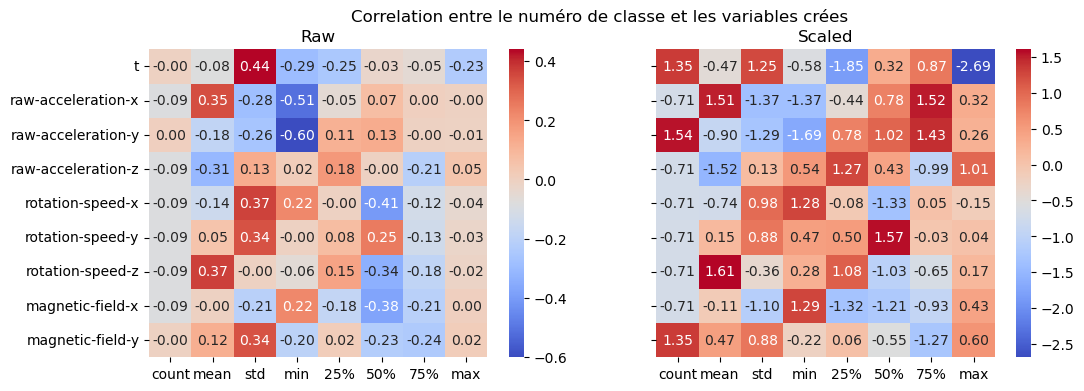

In [3]:
import seaborn as sns
from sklearn.preprocessing import StandardScaler

    # preapre data
label_correlations = to_test.corr()[-1:].iloc[:,:-1]
stats = label_correlations.describe().index.tolist()
r={}
for i, stat_ in enumerate(stats):
    r[stat_] = label_correlations.iloc[:,i*9:(i+1)*9].values.reshape(9)
r = pd.DataFrame(r)
    # prepare figure
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,4))
r.index=['-'.join(a.split('_')[1:]) for a in label_correlations.columns[:9].values]
    # original data
sns.heatmap(r,annot=True,cmap='coolwarm',fmt=".2f",ax=ax1)
ax1.set_title("Raw")
    # scaled sata
sc=StandardScaler()
r=sc.fit_transform(r)
sns.heatmap(r,annot=True,cmap='coolwarm',fmt=".2f",ax=ax2)
ax2.set_xticklabels(stats)
ax2.set_yticklabels("")
ax2.set_title("Scaled")
    # plot
fig.suptitle("Correlation entre le numéro de classe et les variables crées")
plt.show()

Un modele lineaire utilisera les variables les plus correlees au target 'label'

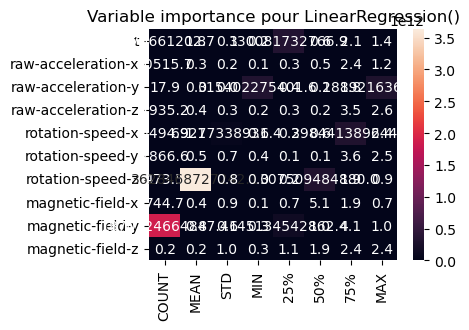

In [4]:
# instancie et fitte le model lineaire
X=sc.fit_transform(to_test.drop("label", axis=1))
y=to_test["label"]
lr = LinearRegression()
lr.fit(X,y)
label_correlations = to_test.corr()[-1:].iloc[:,:-1]
# extract feature importance
coefficients = lr.coef_
feature_importance = pd.DataFrame({'Feature': to_test.columns[:-1], 'Importance': np.abs(coefficients)})
n_stats = feature_importance.Feature.str.startswith('MAX').sum()
stats = ([a.split('_')[0] for a in feature_importance[::n_stats].Feature])
r={}
for i, stat_ in enumerate(stats):
    r[stat_] = feature_importance.iloc[i*n_stats:(i+1)*n_stats,1:].values.reshape(n_stats)
r = pd.DataFrame(r)
r.index=['-'.join(a.split('_')[1:]) for a in label_correlations.columns[:n_stats].values]
plt.figure(figsize=(4,3))
sns.heatmap(r, annot=True, fmt='.1f')
plt.title(f"Variable importance pour {lr}")
plt.show()

On retrouve bien 2 des variables identifiées dans la table de correlation (COUNT_magnetic-field-y et MEAN_rotation-speed-z).\
\
L'analyse les correlation entre des variables lineaire n'a pas de sens ici car nous avons un probleme de classification. A la place on peut utiliser une analyse anova

# Analyse anova



Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/var/folders/dv/gzhyqctn53s9bh23g7tbvl940000gn/T/ipykernel_45581/3497998685.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  annova_results.append(anova_table[metrique][0])
/var/folders/dv/gzhyqctn53s9bh23g7tbvl940000gn/T/ipykernel_45581/3497998685.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  annova_results.append(anova_table[metrique][0])
/var/folders/dv/gzhyqctn53s9bh23g7tbvl940000gn/T/ipykernel_45581/3497998685.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To acc

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/var/folders/dv/gzhyqctn53s9bh23g7tbvl940000gn/T/ipykernel_45581/3497998685.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  annova_results.append(anova_table[metrique][0])
/var/folders/dv/gzhyqctn53s9bh23g7tbvl940000gn/T/ipykernel_45581/3497998685.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  annova_results.append(anova_table[metrique][0])
/var/folders/dv/gzhyqctn53s9bh23g7tbvl940000gn/T/ipykernel_45581/3497998685.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To acc

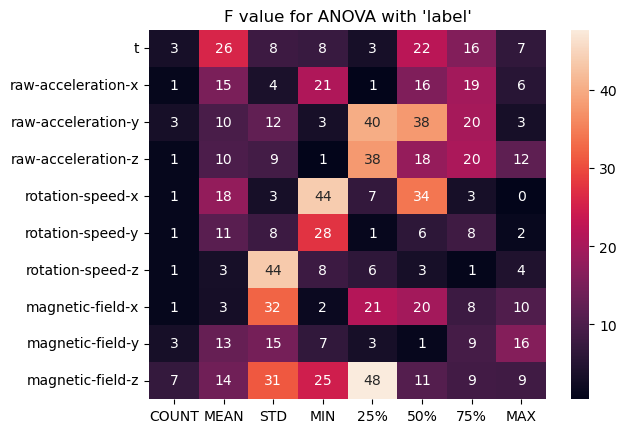

In [5]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

def plot_anova(to_test=to_test, metrique='PR(>F)'):
    """"
    Fonction pour analyser la correlation entre variables continues et classe à prédire
    to_test : pd.DataFrame() 
    metrique : str() une des metrique du module sm.stats.anova_lm ['PR(>F)','F',...]
    """
    df=to_test.copy()
    df['label'] = df['label'].astype('category')
    n_features = len(df.columns[:-1])//8

    df.columns = ['_'+a.replace('%','') for a in df.columns[:-1]]+['label'] # formatage pour sm.stats
    # Loop through each column (except 'label') and perform ANOVA
    annova_results=[]
    for column in df.columns[:-1]:  # Exclude 'label'
        formula = f"{column} ~ label"
        model = ols(formula, data=df).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)
        annova_results.append(anova_table[metrique][0])

    r={}
    for i, stat_ in enumerate(stats):
        r[stat_] = annova_results[i*n_features:(i+1)*n_features]
    s=r
    r = pd.DataFrame(r)
    r.index=['-'.join(a.split('_')[1:]) for a in label_correlations.columns[:n_features].values]
    sns.heatmap((r), annot=True, fmt='.0f')           # mettre au log si P value
    plt.title(f"{metrique} value for ANOVA with 'label'")
    plt.show()
    return r
_ = plot_anova(to_test,'F')

metrique = 'PR(>F)' ==> Si la valeur P globale est petite, il est peu probable que les différences observées soient dues à un échantillonnage aléatoire. Vous pouvez rejeter l'idée que toutes les populations ont des moyennes identiques. Cela ne signifie pas que chaque moyenne diffère de toutes les autres, mais seulement qu'au moins une d'entre elles diffère des autres. 

metrique = 'F' ==> Si l'hypothèse nulle est vraie, vous vous attendez à ce que F ait une valeur proche de 1,0 la plupart du temps. Un rapport F élevé signifie que la variation entre les moyennes des groupes est supérieure à ce que l'on pourrait attendre du hasard. Vous verrez un rapport F élevé à la fois lorsque l'hypothèse nulle est fausse (les données ne sont pas échantillonnées à partir de populations ayant la même moyenne) et lorsque l'échantillonnage aléatoire a abouti à des valeurs élevées dans certains groupes et à des valeurs faibles dans d'autres. 

@ https://www.graphpad.com/guides/prism/latest/statistics/f_ratio_and_anova_table_(one-way_anova).htm
\
\

In [6]:
print("features enregistrées\n",_.sum(axis=1))
print("\nfeautures statistiques\n",_.sum(axis=0))

features enregistrées
 t                      92.625062
raw-acceleration-x     82.019802
raw-acceleration-y    129.527730
raw-acceleration-z    108.810946
rotation-speed-x      110.677290
rotation-speed-y       65.070620
rotation-speed-z       70.404830
magnetic-field-x       97.351390
magnetic-field-y       67.088907
magnetic-field-z      152.675048
dtype: float64

feautures statistiques
 COUNT     22.837171
MEAN     123.193194
STD      165.959552
MIN      144.626930
25%      168.219993
50%      169.031467
75%      113.644340
MAX       68.738976
dtype: float64


* pour les variable eng. (statistiques de la série temporelle), STD 25% et 50% repondent le moins à la null hypothesis (F élevé)
* pour les variables enregistrées, raw-acceleration-y et magnetic-field-z repondent le moins à la null hypothesis (F élevé)

Nous allons tester 3 modèles de classification, regression Logistique, Decision Tree et Random Forest

# Tests de modeles de classification par validation croisée (10 split)

In [7]:

def test_models(to_test=to_test):
    """
    Fonction permettant de tester 4 modèles pour la classification avec 10 split de cross-validation
    to_test : pd.DataFrame()
    """

    X=sc.fit_transform(to_test.drop("label", axis=1))
    y=to_test["label"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    models=[
        LogisticRegression(solver='liblinear'),
        DecisionTreeClassifier(),
        RandomForestClassifier()
    ]

    
    sss = StratifiedShuffleSplit(n_splits=10,test_size=0.3, random_state=42)
    for model in models:
        cv =cross_validate(model,X_train,y_train,cv=sss)
        print(f"{model} score :{round(cv['test_score'].mean(),2)}, time {round(cv['score_time'].mean(),4)}")
    return X, y, X_train, X_test, y_train, y_test

X, y, X_train, X_test, y_train, y_test = test_models(to_test)



LogisticRegression(solver='liblinear') score :0.84, time 0.0006
DecisionTreeClassifier() score :0.64, time 0.0003
RandomForestClassifier() score :0.95, time 0.0043


Le modèle de bagging (RandomForest) donne les meilleur scores

Nous pouvons utiliser un grille de recherche d'hyperparamtere pour améliorer les modèles

In [8]:
import numpy as np
from sklearn.model_selection import RandomizedSearchCV

def optimize_logreg(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test):
    logreg_model = LogisticRegression(multi_class='auto', solver='liblinear')

    param_grid = {
        'C': np.logspace(-4, 4, 40),  
        'penalty': ['l1', 'l2'], 
        'max_iter': [1000, 10000],  
    }
    sss = StratifiedShuffleSplit(n_splits=10,test_size=0.3, random_state=42)
    random_search = RandomizedSearchCV(logreg_model, 
                                    param_distributions=param_grid, 
                                    n_iter=10, 
                                    scoring='accuracy', 
                                    cv=sss, 
                                    random_state=42,
                                    refit=True)
    

    random_search.fit(X_train, y_train)
    t0 = time.time()
    y_pred = random_search.best_estimator_.predict(X_test)
    t_fit = time.time()-t0
    from sklearn.metrics import classification_report
    print(classification_report(y_test,y_pred))
    print("fit time :",round(t_fit,4))
    print("best param",random_search.best_params_)
    return random_search

random_search = optimize_logreg(X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

           0       1.00      0.83      0.91         6
           1       0.80      0.57      0.67         7
           2       0.88      1.00      0.93         7
           3       0.80      0.67      0.73         6
           4       1.00      1.00      1.00         6
           5       0.57      0.57      0.57         7
           6       0.78      1.00      0.88         7
           7       0.70      1.00      0.82         7
           8       1.00      1.00      1.00         8
           9       1.00      0.67      0.80         6

    accuracy                           0.84        67
   macro avg       0.85      0.83      0.83        67
weighted avg       0.85      0.84      0.83        67

fit time : 0.0022
best param {'penalty': 'l1', 'max_iter': 1000, 'C': 34.55107294592218}


* temps de fit court

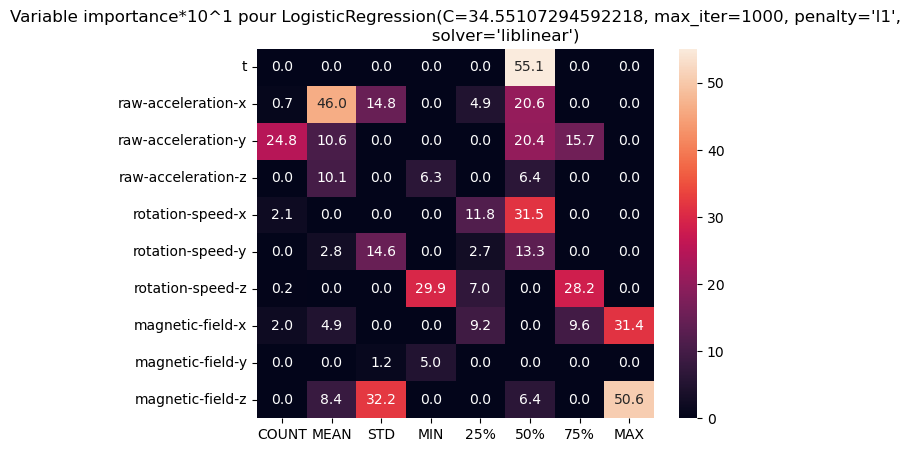

In [9]:
def feat_importance_logreg(random_search=random_search, to_test=to_test, show=False):
    # fit the model with best params from random search
    p_ = random_search.best_params_
    model_lr = LogisticRegression(**p_,solver='liblinear')
    model_lr.fit(X, y)

    if show:
        label_correlations = to_test.corr()[-1:].iloc[:,:-1]
        # extract feature importance
        coefficients = model_lr.coef_[0]
        feature_importance = pd.DataFrame({'Feature': to_test.columns[:-1], 'Importance': np.abs(coefficients)})
        n_stats = feature_importance.Feature.str.startswith('MAX').sum()
        stats = ([a.split('_')[0] for a in feature_importance[::n_stats].Feature])
        r={}
        for i, stat_ in enumerate(stats):
            r[stat_] = feature_importance.iloc[i*n_stats:(i+1)*n_stats,1:].values.reshape(n_stats)
        r = pd.DataFrame(r)
        r.index=['-'.join(a.split('_')[1:]) for a in label_correlations.columns[:n_stats].values]
        sns.heatmap(r*10, annot=True, fmt='.1f')
        plt.title(f"Variable importance*10^1 pour {model_lr}")
        plt.show()
    return model_lr
model_lr = feat_importance_logreg(random_search, to_test, show=True)


* 3 featrures haut coeff_
* 50%_t, 50%_raw_acceleration-y, 50%_rotation-speed-x, STD_magnetic-field-z identifiées par ANOVA

In [10]:
def optimize_rfc(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test):
    param_grid = {
        'n_estimators': [50, 100, 200, 300],
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 10, 20, 30, 40, 50],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4, 8],
        'max_features': ['auto', 'sqrt', 'log2'],
    }

    random_search = RandomizedSearchCV(RandomForestClassifier(), 
                                    param_distributions=param_grid, 
                                    n_iter=10, 
                                    scoring='accuracy', 
                                    cv=5, 
                                    random_state=42, 
                                    refit=True)
    random_search.fit(X_train, y_train)

    start_time = time.time()
    y_pred = random_search.best_estimator_.predict(X_test)
    end_time = time.time()

    print("best estimator",random_search.best_estimator_)
    print(classification_report(y_test,y_pred))
    print("time to predict :",round(end_time - start_time,4))
    print("best params: ",random_search.best_params_)
    return random_search

random_search = optimize_rfc(X_train, y_train, X_test, y_test)

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is 

best estimator RandomForestClassifier(criterion='entropy', max_depth=50, min_samples_split=5,
                       n_estimators=200)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         7
           3       1.00      0.83      0.91         6
           4       1.00      0.67      0.80         6
           5       0.78      1.00      0.88         7
           6       0.88      1.00      0.93         7
           7       1.00      1.00      1.00         7
           8       1.00      1.00      1.00         8
           9       1.00      1.00      1.00         6

    accuracy                           0.96        67
   macro avg       0.97      0.95      0.95        67
weighted avg       0.96      0.96      0.95        67

time to predict : 0.0075
best params:  {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1

* identifie assez mal '5' et '6'

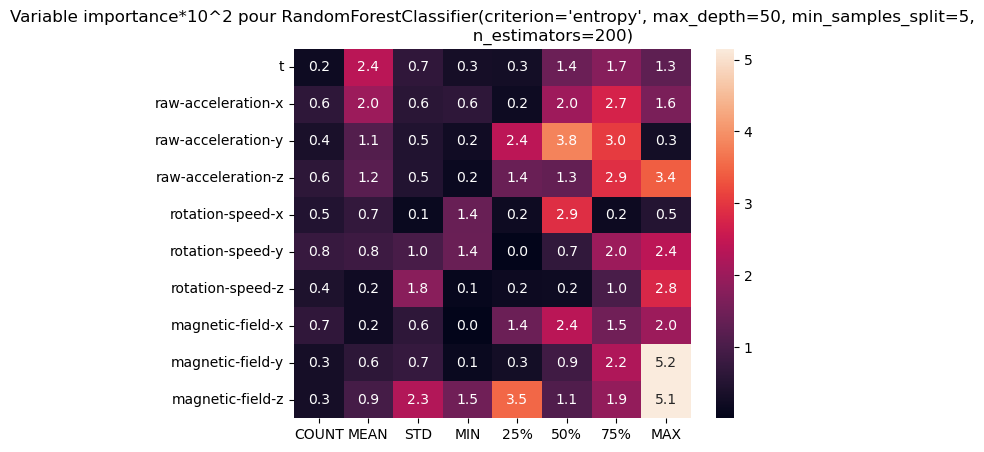

In [11]:

import numpy as np
def feat_importance_rfc(random_search=random_search, to_test=to_test, show=False):
    # fit the model with best params from random search
    p_ = random_search.best_params_
    model_rfc = RandomForestClassifier(**p_)
    model_rfc.fit(X, y)

    if show:
        label_correlations = to_test.corr()[-1:].iloc[:,:-1]
        # extract feature importance
        coefficients = model_rfc.feature_importances_
        feature_importance = pd.DataFrame({'Feature': label_correlations.columns, 'Importance': np.abs(coefficients)})
        n_stats = feature_importance.Feature.str.startswith('MAX').sum()
        stats = ([a.split('_')[0] for a in feature_importance[::n_stats].Feature])
        r={}
        for i, stat_ in enumerate(stats):
            r[stat_] = feature_importance.iloc[i*n_stats:(i+1)*n_stats,1:].values.reshape(n_stats)
        s=r
        r = pd.DataFrame(r)
        r.index=['-'.join(a.split('_')[1:]) for a in label_correlations.columns[:n_stats].values]
        sns.heatmap(r*100, annot=True, fmt='.1f')
        plt.title(f"Variable importance*10^2 pour {model_rfc}")
        plt.show()

    return model_rfc
model_rfc = feat_importance_rfc(random_search, to_test, show=True)


* 5 features haut coeff
* identifie bien STD_magnetic-field-z de l'ANOVA

* ==> DecisionTreeClassifier

# test des modeles sur l'autre dataset horizontal (équipe differente)

In [12]:
to_test1 = load_data('data/h_config1-lcb')
X, y, X_train, X_test, y_train, y_test = test_models(to_test1)

LogisticRegression(solver='liblinear') score :0.87, time 0.0003
DecisionTreeClassifier() score :0.74, time 0.0003
RandomForestClassifier() score :0.93, time 0.004


### regression logistique

              precision    recall  f1-score   support

           0       0.52      0.55      0.53        31
           1       0.25      0.43      0.31        30
           2       0.28      0.37      0.32        30
           3       0.11      0.13      0.12        30
           4       0.15      0.06      0.09        33
           5       0.36      0.80      0.49        30
           6       0.07      0.03      0.04        30
           7       0.68      0.43      0.53        30
           8       0.07      0.03      0.04        31
           9       0.19      0.10      0.13        30

    accuracy                           0.29       305
   macro avg       0.27      0.29      0.26       305
weighted avg       0.27      0.29      0.26       305



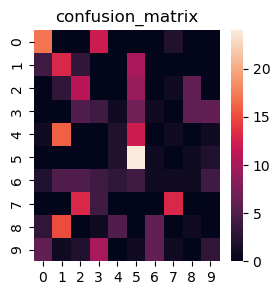

In [13]:
y_pred = model_lr.predict(X=sc.fit_transform(to_test1.drop("label", axis=1)))
from sklearn.metrics import confusion_matrix
plt.figure(figsize=(3,3))
sns.heatmap(confusion_matrix(to_test1["label"], y_pred))
plt.title("confusion_matrix")
print(classification_report(to_test1["label"], y_pred))

### random forest classifier

In [14]:
y_pred = model_rfc.predict(X=sc.fit_transform(to_test1.drop("label", axis=1)))
from sklearn.metrics import confusion_matrix
plt.figure(figsize=(3,3))
sns.heatmap(confusion_matrix(to_test1["label"], y_pred))
plt.title("confusion_matrix")
print(classification_report(to_test1["label"], y_pred))

NameError: name 'to_test2' is not defined

## entrainement sur tout les datasets

Text(0.5, 1.0, 'repartition des données entre chaque classe')

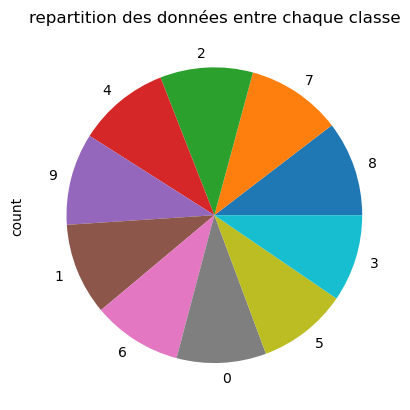

In [ ]:
load_data(directory = 'data/group3/config_1', drop_col='', drop_feat='')


to_test                                         # horizontal
to_test1 #= load_data('data/h_config1-lcb')      # horizontal
to_test2 = load_data('data/v_config1-lcb')      # vertical
to_test3 = load_data('data/groupe1_groupe2')  # 3D
to_test4 = pd.concat([to_test,to_test1, to_test2, to_test3], axis=0)

to_test4.label.value_counts().plot.pie()
plt.title("repartition des données entre chaque classe")

In [ ]:
X, y, X_train, X_test, y_train, y_test = test_models(to_test4)

LogisticRegression(solver='liblinear') score :0.58, time 0.0005
DecisionTreeClassifier() score :0.49, time 0.0004
RandomForestClassifier() score :0.81, time 0.0062


In [ ]:
random_search1 = optimize_logreg(X_train, y_train, X_test, y_test)

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.79      0.65      0.71        34
           1       0.84      0.74      0.79        35
           2       0.68      0.66      0.67        35
           3       0.72      0.70      0.71        33
           4       0.55      0.60      0.58        35
           5       0.65      0.65      0.65        34
           6       0.51      0.56      0.54        34
           7       0.72      0.72      0.72        36
           8       0.73      0.75      0.74        36
           9       0.75      0.86      0.80        35

    accuracy                           0.69       347
   macro avg       0.69      0.69      0.69       347
weighted avg       0.69      0.69      0.69       347

fit time : 0.0003
best param {'penalty': 'l2', 'max_iter': 1000, 'C': 13.433993325988988}


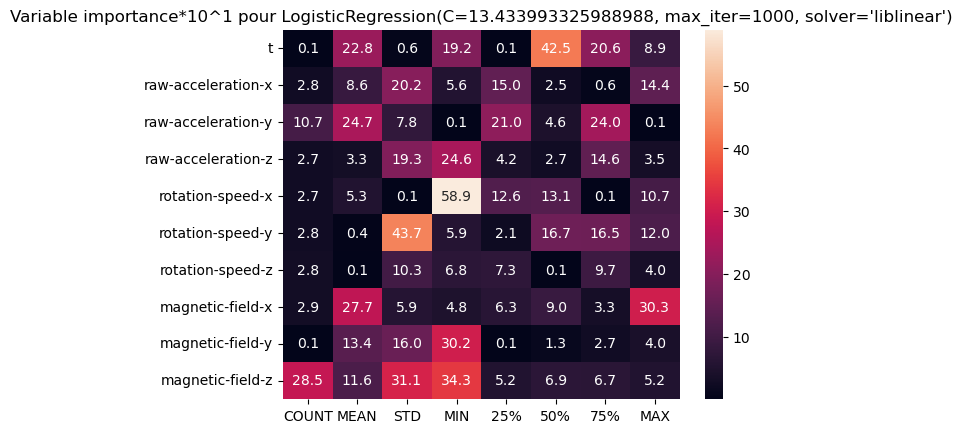

In [ ]:
model_lr1 = feat_importance_logreg(random_search, to_test4, show=True)

In [ ]:
random_search2 = optimize_rfc(X_train, y_train, X_test, y_test)

In [ ]:
model_rfc2 = feat_importance_rfc(random_search, to_test4, show=True)

## generalisaton avec un model plus parcimonieux

LogisticRegression(solver='liblinear') score :0.76, time 0.0012
DecisionTreeClassifier() score :0.79, time 0.0003
RandomForestClassifier() score :0.92, time 0.0046


/Applications/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.50      0.33      0.40         6
           1       0.75      0.43      0.55         7
           2       0.78      1.00      0.88         7
           3       0.75      0.50      0.60         6
           4       0.50      0.50      0.50         6
           5       0.22      0.29      0.25         7
           6       0.62      0.71      0.67         7
           7       0.70      1.00      0.82         7
           8       0.67      0.50      0.57         8
           9       0.71      0.83      0.77         6

    accuracy                           0.61        67
   macro avg       0.62      0.61      0.60        67
weighted avg       0.62      0.61      0.60        67

fit time : 0.0001


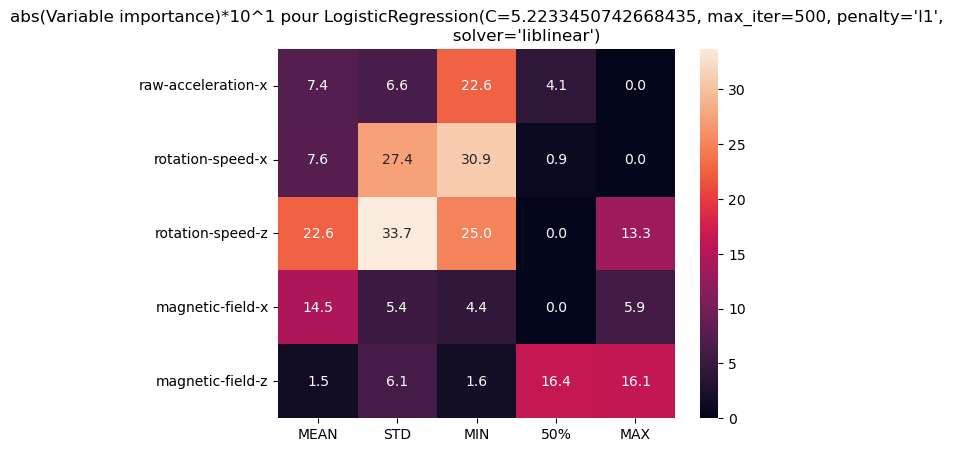

              precision    recall  f1-score   support

           0       0.38      0.10      0.15        31
           1       0.03      0.03      0.03        30
           2       0.16      0.20      0.18        30
           3       0.15      0.27      0.19        30
           4       0.09      0.12      0.10        33
           5       0.48      0.47      0.47        30
           6       0.10      0.03      0.05        30
           7       0.41      0.43      0.42        30
           8       0.12      0.03      0.05        31
           9       0.23      0.33      0.27        30

    accuracy                           0.20       305
   macro avg       0.21      0.20      0.19       305
weighted avg       0.21      0.20      0.19       305



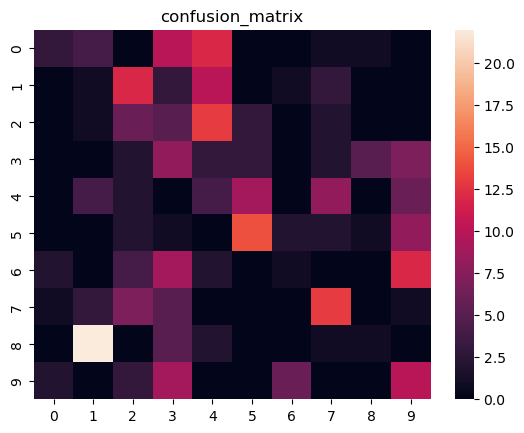

In [ ]:
####### log reg

f_ = ['count', '25%', '75%']
c_ = ['t','raw_acceleration_y' ,'raw_acceleration_z', 'rotation_speed_y', 'magnetic_field_y']

to_test = load_data(directory = 'data/group3/config_1', drop_col=c_, drop_feat=f_)

X, y, X_train, X_test, y_train, y_test = test_models(to_test)
random_search = optimize_logreg(X_train, y_train, X_test, y_test)
model_lr = feat_importance_logreg(random_search, to_test, show=True)

to_test2 = load_data(directory = 'data/h_config1-lcb', drop_col=c_, drop_feat=f_)

y_pred = model_lr.predict(X=sc.fit_transform(to_test2.drop("label", axis=1)))
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(to_test2["label"], y_pred))
plt.title("confusion_matrix")
print(classification_report(to_test2["label"], y_pred))

# conclusion
* Le modèle entrainé sur une seul dataset (dont l'aquisition s'est faite de facon similaire - c.a. tracer les chiffres sur le plan d'une table) n'est pas generalisable
* il faut augmenter le nombre de données pour l'entrainement en combinant les datasets

# Feature importance configuration 3 == quaternions

In [ ]:
to_test4 = load_data('data/group3/config_3')

/var/folders/dv/gzhyqctn53s9bh23g7tbvl940000gn/T/ipykernel_33360/1462667111.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  annova_results.append(anova_table[metrique][0])
/var/folders/dv/gzhyqctn53s9bh23g7tbvl940000gn/T/ipykernel_33360/1462667111.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  annova_results.append(anova_table[metrique][0])
/var/folders/dv/gzhyqctn53s9bh23g7tbvl940000gn/T/ipykernel_33360/1462667111.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To acc

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


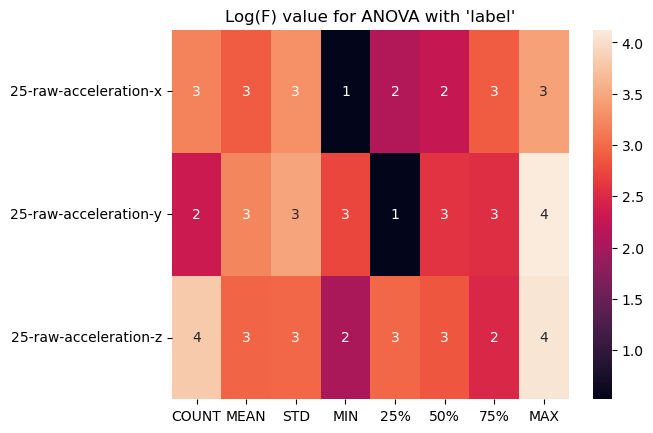

''

In [ ]:
def plot_anova_quaternion(to_test4=to_test4, metrique='PR(>F)'):
    df=to_test2.copy()
    df['label'] = df['label'].astype('category')
    n_features = len(df.columns[:-1])//8
    df.columns = ['_'+a.replace('%','') for a in df.columns[:-1]]+['label'] # formatage pour sm.stats
    # Loop through each column (except 'label') and perform ANOVA
    annova_results=[]
    for column in df.columns[:-1]:  # Exclude 'label'
        formula = f"{column} ~ label"
        model = ols(formula, data=df).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)
        annova_results.append(anova_table[metrique][0])
    r={}
    for i, stat_ in enumerate(stats):
        r[stat_] = annova_results[i*n_features:(i+1)*n_features]
    s=r
    r = pd.DataFrame(r)
    r.index=['-'.join(a.split('_')[1:]) for a in df.columns[:n_features].values]
    sns.heatmap(np.log(r), annot=True, fmt='.0f')           # mettre au log si P value
    plt.title(f"Log({metrique}) value for ANOVA with 'label'")
    plt.show()
    return ''
plot_anova_quaternion(to_test4=to_test4, metrique='F')

In [ ]:
X, y, X_train, X_test, y_train, y_test = test_models(to_test4)

LogisticRegression(solver='liblinear') score :0.96, time 0.0003
DecisionTreeClassifier() score :0.91, time 0.0003
RandomForestClassifier() score :0.98, time 0.0038


In [ ]:
# results config 1

# LinearRegression() score :-0.25, time -0.0002
# LogisticRegression(solver='liblinear') score :0.86, time -0.0003
# DecisionTreeClassifier() score :0.73, time -0.0003
# RandomForestClassifier() score :0.98, time -0.0036

In [ ]:
to_test4 = load_data('data/group3/config_3', drop_col='t')
X, y, X_train, X_test, y_train, y_test = test_models(to_test4)

LogisticRegression(solver='liblinear') score :0.95, time 0.0004
DecisionTreeClassifier() score :0.87, time 0.0003
RandomForestClassifier() score :0.98, time 0.004


In [ ]:
to_test4 = load_data('data/group3/config_3', drop_feat='count')
X, y, X_train, X_test, y_train, y_test = test_models(to_test4)

LogisticRegression(solver='liblinear') score :0.95, time 0.0003
DecisionTreeClassifier() score :0.9, time 0.0003
RandomForestClassifier() score :0.98, time 0.0039


In [ ]:
to_test4 = load_data('data/group3/config_3', drop_col='t', drop_feat=['count','25%'])
X, y, X_train, X_test, y_train, y_test = test_models(to_test4)

LogisticRegression(solver='liblinear') score :0.92, time 0.0003
DecisionTreeClassifier() score :0.88, time 0.0003
RandomForestClassifier() score :0.97, time 0.004


* l'utilisation des quaternions permettent les meilleurs resulatts de classification